In [1]:
# Reload modules whenever underlying code changes
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
from sgm.dependencies import *


Bad key savefig.frameon in file /home/mgaltier200/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /home/mgaltier200/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /home/mgaltier200/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.stdout or sys.stderr')
You probably 

In [3]:
from sgm.envs import env_load_fn
from sgm.agent import UvfAgent
from sgm.trainer import train_eval
from sgm.envs import *
from scipy.spatial import distance
from sgm.evaluation import cleanup_and_eval
from sgm.planner import SoRBSearchPolicy
    
def generalized_difficulty(resize_factor):
    tf.reset_default_graph()

    # If you change the environment parameters below, make sure to run
    # tf.reset_default_graph() in the cell above before training.
    max_episode_steps = 20
    env_name = 'FourRooms'  # Choose one of the environments shown above. 
    resize_factor = resize_factor  # Inflate the environment to increase the difficulty.
    thin = True # If True, resize by expanding open space, not walls, to make walls thin
    desc_name = "thinned_" + env_name.lower() if thin else env_name.lower()

    base_dir = os.path.join(os.getcwd(), os.pardir, "agents")
    model_dir = os.path.join(base_dir, desc_name)

    tf_env = env_load_fn(env_name, max_episode_steps,
                         resize_factor=resize_factor,
                         terminate_on_timeout=False,
                         thin=thin)
    eval_tf_env = env_load_fn(env_name, max_episode_steps,
                              resize_factor=resize_factor,
                              terminate_on_timeout=True,
                              thin=thin)

    agent = UvfAgent(
        tf_env.time_step_spec(),
        tf_env.action_spec(),
        max_episode_steps=max_episode_steps,
        use_distributional_rl=True,
        ensemble_size=3)



    train_eval(agent,
              tf_env,
              eval_tf_env,
              initial_collect_steps=1000,
              eval_interval=1000,
              num_eval_episodes=10,
              num_iterations=30000,
              save_model_dir=model_dir,
              experiment_name=f"{resize_factor}_{env_name}_coordinate_{max_episode_steps}steps")

    filename = str(resize_factor)+"_FourRooms_coordinate_20steps-Dec-05-2019-12-58-28-PM/ckpt/"
    checkpoint_file = os.path.join(model_dir, filename)

    ckpt = tf.train.Checkpoint(step=tf.Variable(1), net=agent)
    manager = tf.train.CheckpointManager(ckpt, checkpoint_file, max_to_keep=3)
    ckpt.restore(manager.latest_checkpoint)

    #@title Fill the replay buffer with random data  {vertical-output: true, run: "auto" }
    replay_buffer_size = 2000 #@param {min:100, max: 1000, step: 100, type:"slider"}

    eval_tf_env.pyenv.envs[0].gym.set_sample_goal_args(
        prob_constraint=0.0,
        min_dist=0,
        max_dist=np.inf)
    rb_vec = []
    for it in range(replay_buffer_size):
        ts = eval_tf_env.reset()
        rb_vec.append(ts.observation['observation'].numpy()[0])
    rb_vec = np.array(rb_vec)


    plt.figure(figsize=(6, 6))
    plt.scatter(*rb_vec.T)
    plot_walls(eval_tf_env.pyenv.envs[0].env.walls)
    plt.show()

    pdist = agent._get_pairwise_dist(rb_vec, aggregate=None).numpy()

    plt.figure(figsize=(6, 3))
    plt.hist(pdist.flatten(), bins=range(20))
    plt.xlabel('predicted distance')
    plt.ylabel('number of (s, g) pairs')
    plt.show()

    euclidean_dists = distance.pdist(rb_vec)

    plt.figure(figsize=(6, 3))
    plt.hist(euclidean_dists.flatten())
    plt.xlabel('Euclidean distance')
    plt.ylabel('number of pairwise distances')
    plt.show()

    search_policy_type = "SoRB"
    agent.initialize_search(rb_vec, max_search_steps=6)
    search_policy = SoRBSearchPolicy(agent, pdist, rb_vec)


    logdir = os.path.join(os.getcwd(), os.pardir, "logs")
    eval_difficulty = 0.95
    k_nearest = 5
    eval_trials = 20
    total_cleanup_steps = 50000
    eval_period = 5000

    logfolder = cleanup_and_eval(search_policy,
                                 search_policy_type,
                                 desc_name,
                                 eval_tf_env,
                                 logdir,
                                 eval_difficulty=eval_difficulty,
                                 k_nearest=k_nearest,
                                 eval_trials=eval_trials,
                                 total_cleanup_steps=total_cleanup_steps,
                                 eval_period=eval_period)

/home/mgaltier200/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))



INFO:tensorflow:random_seed = 0
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Saving checkpoints to directory /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/5_FourRooms_coordinate_20steps-May-17-2021-09-08-52-PM/ckpt
INFO:tensorflow:Creating tensorboard summary writer with directory /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/5_FourRooms_coordinate_20steps-May-17-2021-09-08-52-PM
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



  3%|▎         | 995/30000 [00:20<08:25, 57.36it/s] 

Saved checkpoint for step 1000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/5_FourRooms_coordinate_20steps-May-17-2021-09-08-52-PM/ckpt/ckpt-1
INFO:tensorflow:step = 1000, loss = 2.215829
INFO:tensorflow:52.915 steps/sec
INFO:tensorflow:step = 1000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -18.30
INFO:tensorflow:		 predicted_dist = 15.9 (0.5)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -18.70
INFO:tensorflow:		 predicted_dist = 15.7 (0.8)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -19.40
INFO:tensorflow:		 predicted_dist = 16.2 (0.3)
INFO:tensorflow:	 eval_time = 3.86


  7%|▋         | 1996/30000 [00:41<08:31, 54.73it/s]  

Saved checkpoint for step 2000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/5_FourRooms_coordinate_20steps-May-17-2021-09-08-52-PM/ckpt/ckpt-2
INFO:tensorflow:step = 2000, loss = 1.052865
INFO:tensorflow:62.657 steps/sec
INFO:tensorflow:step = 2000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -14.70
INFO:tensorflow:		 predicted_dist = 17.9 (0.6)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -20.00
INFO:tensorflow:		 predicted_dist = 17.8 (0.9)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -19.70
INFO:tensorflow:		 predicted_dist = 18.8 (0.4)
INFO:tensorflow:	 eval_time = 2.86


 10%|▉         | 2999/30000 [01:01<09:00, 50.00it/s]  

Saved checkpoint for step 3000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/5_FourRooms_coordinate_20steps-May-17-2021-09-08-52-PM/ckpt/ckpt-3
INFO:tensorflow:step = 3000, loss = 1.056860
INFO:tensorflow:61.693 steps/sec
INFO:tensorflow:step = 3000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -14.90
INFO:tensorflow:		 predicted_dist = 16.1 (0.4)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -19.40
INFO:tensorflow:		 predicted_dist = 16.7 (1.5)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -20.00
INFO:tensorflow:		 predicted_dist = 17.9 (1.0)
INFO:tensorflow:	 eval_time = 3.15


 13%|█▎        | 3999/30000 [01:22<08:17, 52.25it/s]  

Saved checkpoint for step 4000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/5_FourRooms_coordinate_20steps-May-17-2021-09-08-52-PM/ckpt/ckpt-4
INFO:tensorflow:step = 4000, loss = 1.256776
INFO:tensorflow:62.659 steps/sec
INFO:tensorflow:step = 4000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -14.80
INFO:tensorflow:		 predicted_dist = 16.7 (0.4)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -17.40
INFO:tensorflow:		 predicted_dist = 17.1 (0.9)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -20.00
INFO:tensorflow:		 predicted_dist = 18.1 (0.5)
INFO:tensorflow:	 eval_time = 2.84


 17%|█▋        | 4993/30000 [01:42<06:53, 60.43it/s]  

Saved checkpoint for step 5000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/5_FourRooms_coordinate_20steps-May-17-2021-09-08-52-PM/ckpt/ckpt-5
INFO:tensorflow:step = 5000, loss = 1.434889
INFO:tensorflow:60.642 steps/sec
INFO:tensorflow:step = 5000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -12.50
INFO:tensorflow:		 predicted_dist = 13.6 (1.7)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -17.90
INFO:tensorflow:		 predicted_dist = 16.1 (1.2)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -20.00
INFO:tensorflow:		 predicted_dist = 16.9 (1.3)
INFO:tensorflow:	 eval_time = 2.64


 20%|█▉        | 5996/30000 [02:03<06:55, 57.73it/s]

Saved checkpoint for step 6000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/5_FourRooms_coordinate_20steps-May-17-2021-09-08-52-PM/ckpt/ckpt-6
INFO:tensorflow:step = 6000, loss = 1.640416
INFO:tensorflow:61.819 steps/sec
INFO:tensorflow:step = 6000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -14.70
INFO:tensorflow:		 predicted_dist = 16.4 (1.0)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -20.00
INFO:tensorflow:		 predicted_dist = 17.5 (1.0)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -17.90
INFO:tensorflow:		 predicted_dist = 18.0 (0.7)
INFO:tensorflow:	 eval_time = 2.87


 23%|██▎       | 6995/30000 [02:24<06:54, 55.50it/s]  

Saved checkpoint for step 7000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/5_FourRooms_coordinate_20steps-May-17-2021-09-08-52-PM/ckpt/ckpt-7
INFO:tensorflow:step = 7000, loss = 1.161751
INFO:tensorflow:60.771 steps/sec
INFO:tensorflow:step = 7000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -12.30
INFO:tensorflow:		 predicted_dist = 13.9 (2.0)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -18.50
INFO:tensorflow:		 predicted_dist = 17.4 (0.8)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -19.00
INFO:tensorflow:		 predicted_dist = 18.2 (0.4)
INFO:tensorflow:	 eval_time = 3.04


 27%|██▋       | 7997/30000 [02:44<06:21, 57.74it/s]  

Saved checkpoint for step 8000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/5_FourRooms_coordinate_20steps-May-17-2021-09-08-52-PM/ckpt/ckpt-8
INFO:tensorflow:step = 8000, loss = 1.467005
INFO:tensorflow:61.336 steps/sec
INFO:tensorflow:step = 8000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -12.10
INFO:tensorflow:		 predicted_dist = 15.7 (0.9)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -18.40
INFO:tensorflow:		 predicted_dist = 16.6 (0.7)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -19.90
INFO:tensorflow:		 predicted_dist = 17.7 (0.5)
INFO:tensorflow:	 eval_time = 2.89


 30%|██▉       | 8998/30000 [03:05<06:05, 57.38it/s]

Saved checkpoint for step 9000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/5_FourRooms_coordinate_20steps-May-17-2021-09-08-52-PM/ckpt/ckpt-9
INFO:tensorflow:step = 9000, loss = 1.406763
INFO:tensorflow:60.895 steps/sec
INFO:tensorflow:step = 9000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -16.70
INFO:tensorflow:		 predicted_dist = 14.3 (2.6)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -16.90
INFO:tensorflow:		 predicted_dist = 17.3 (1.1)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -19.30
INFO:tensorflow:		 predicted_dist = 17.5 (1.1)
INFO:tensorflow:	 eval_time = 3.12


 33%|███▎      | 9995/30000 [03:25<05:18, 62.76it/s]

Saved checkpoint for step 10000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/5_FourRooms_coordinate_20steps-May-17-2021-09-08-52-PM/ckpt/ckpt-10
INFO:tensorflow:step = 10000, loss = 1.398670
INFO:tensorflow:62.275 steps/sec
INFO:tensorflow:step = 10000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -15.80
INFO:tensorflow:		 predicted_dist = 16.3 (0.6)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -16.70
INFO:tensorflow:		 predicted_dist = 17.3 (0.7)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -20.00
INFO:tensorflow:		 predicted_dist = 18.1 (0.4)
INFO:tensorflow:	 eval_time = 2.91


 37%|███▋      | 10998/30000 [03:47<06:12, 50.96it/s]

Saved checkpoint for step 11000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/5_FourRooms_coordinate_20steps-May-17-2021-09-08-52-PM/ckpt/ckpt-11
INFO:tensorflow:step = 11000, loss = 1.333713
INFO:tensorflow:59.398 steps/sec
INFO:tensorflow:step = 11000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -14.70
INFO:tensorflow:		 predicted_dist = 14.5 (1.9)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -16.70
INFO:tensorflow:		 predicted_dist = 16.8 (1.0)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -18.70
INFO:tensorflow:		 predicted_dist = 18.1 (0.8)
INFO:tensorflow:	 eval_time = 3.09


 40%|███▉      | 11997/30000 [04:08<05:19, 56.40it/s]

Saved checkpoint for step 12000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/5_FourRooms_coordinate_20steps-May-17-2021-09-08-52-PM/ckpt/ckpt-12
INFO:tensorflow:step = 12000, loss = 1.749749
INFO:tensorflow:58.394 steps/sec
INFO:tensorflow:step = 12000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -8.20
INFO:tensorflow:		 predicted_dist = 12.8 (2.8)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -16.00
INFO:tensorflow:		 predicted_dist = 15.5 (1.0)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -18.40
INFO:tensorflow:		 predicted_dist = 16.3 (1.2)
INFO:tensorflow:	 eval_time = 2.91


 43%|████▎     | 12999/30000 [04:30<06:03, 46.73it/s]

Saved checkpoint for step 13000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/5_FourRooms_coordinate_20steps-May-17-2021-09-08-52-PM/ckpt/ckpt-13
INFO:tensorflow:step = 13000, loss = 2.200151
INFO:tensorflow:57.811 steps/sec
INFO:tensorflow:step = 13000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -12.60
INFO:tensorflow:		 predicted_dist = 12.2 (1.8)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -15.00
INFO:tensorflow:		 predicted_dist = 14.0 (1.9)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -17.60
INFO:tensorflow:		 predicted_dist = 16.7 (0.9)
INFO:tensorflow:	 eval_time = 3.05


 47%|████▋     | 13996/30000 [04:52<04:41, 56.94it/s]

Saved checkpoint for step 14000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/5_FourRooms_coordinate_20steps-May-17-2021-09-08-52-PM/ckpt/ckpt-14
INFO:tensorflow:step = 14000, loss = 2.358073
INFO:tensorflow:58.073 steps/sec
INFO:tensorflow:step = 14000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -11.80
INFO:tensorflow:		 predicted_dist = 11.1 (1.0)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -15.40
INFO:tensorflow:		 predicted_dist = 13.9 (1.5)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -18.60
INFO:tensorflow:		 predicted_dist = 15.2 (1.0)
INFO:tensorflow:	 eval_time = 3.01


 50%|████▉     | 14995/30000 [05:14<05:03, 49.47it/s]

Saved checkpoint for step 15000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/5_FourRooms_coordinate_20steps-May-17-2021-09-08-52-PM/ckpt/ckpt-15
INFO:tensorflow:step = 15000, loss = 2.699140
INFO:tensorflow:57.958 steps/sec
INFO:tensorflow:step = 15000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -16.40
INFO:tensorflow:		 predicted_dist = 11.1 (1.7)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -14.40
INFO:tensorflow:		 predicted_dist = 13.1 (1.1)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -17.10
INFO:tensorflow:		 predicted_dist = 14.5 (0.6)
INFO:tensorflow:	 eval_time = 2.78


 53%|█████▎    | 15995/30000 [05:35<03:59, 58.44it/s]

Saved checkpoint for step 16000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/5_FourRooms_coordinate_20steps-May-17-2021-09-08-52-PM/ckpt/ckpt-16
INFO:tensorflow:step = 16000, loss = 2.374706
INFO:tensorflow:59.440 steps/sec
INFO:tensorflow:step = 16000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -4.80
INFO:tensorflow:		 predicted_dist = 11.5 (2.1)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -12.60
INFO:tensorflow:		 predicted_dist = 13.5 (0.9)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -18.30
INFO:tensorflow:		 predicted_dist = 14.7 (1.1)
INFO:tensorflow:	 eval_time = 2.61


 57%|█████▋    | 16995/30000 [05:56<04:13, 51.38it/s]

Saved checkpoint for step 17000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/5_FourRooms_coordinate_20steps-May-17-2021-09-08-52-PM/ckpt/ckpt-17
INFO:tensorflow:step = 17000, loss = 2.643093
INFO:tensorflow:58.525 steps/sec
INFO:tensorflow:step = 17000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -7.50
INFO:tensorflow:		 predicted_dist = 8.5 (3.1)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -11.50
INFO:tensorflow:		 predicted_dist = 13.1 (1.2)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -16.90
INFO:tensorflow:		 predicted_dist = 15.2 (0.9)
INFO:tensorflow:	 eval_time = 2.49


 60%|█████▉    | 17997/30000 [06:17<03:33, 56.29it/s]

Saved checkpoint for step 18000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/5_FourRooms_coordinate_20steps-May-17-2021-09-08-52-PM/ckpt/ckpt-18
INFO:tensorflow:step = 18000, loss = 2.580304
INFO:tensorflow:58.758 steps/sec
INFO:tensorflow:step = 18000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -3.20
INFO:tensorflow:		 predicted_dist = 7.4 (1.9)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -12.30
INFO:tensorflow:		 predicted_dist = 11.7 (1.7)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -17.30
INFO:tensorflow:		 predicted_dist = 13.5 (0.9)
INFO:tensorflow:	 eval_time = 2.49


 63%|██████▎   | 18995/30000 [06:39<03:10, 57.66it/s]

Saved checkpoint for step 19000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/5_FourRooms_coordinate_20steps-May-17-2021-09-08-52-PM/ckpt/ckpt-19
INFO:tensorflow:step = 19000, loss = 2.565112
INFO:tensorflow:58.497 steps/sec
INFO:tensorflow:step = 19000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -4.50
INFO:tensorflow:		 predicted_dist = 8.1 (1.3)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -10.30
INFO:tensorflow:		 predicted_dist = 10.7 (0.8)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -16.30
INFO:tensorflow:		 predicted_dist = 13.6 (1.0)
INFO:tensorflow:	 eval_time = 2.41


 67%|██████▋   | 19998/30000 [07:00<02:36, 63.99it/s]

Saved checkpoint for step 20000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/5_FourRooms_coordinate_20steps-May-17-2021-09-08-52-PM/ckpt/ckpt-20
INFO:tensorflow:step = 20000, loss = 2.430877
INFO:tensorflow:57.666 steps/sec
INFO:tensorflow:step = 20000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -4.80
INFO:tensorflow:		 predicted_dist = 7.8 (1.9)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -12.10
INFO:tensorflow:		 predicted_dist = 10.9 (1.1)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -16.90
INFO:tensorflow:		 predicted_dist = 12.6 (1.0)
INFO:tensorflow:	 eval_time = 2.33


 70%|██████▉   | 20994/30000 [07:21<02:13, 67.70it/s]

Saved checkpoint for step 21000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/5_FourRooms_coordinate_20steps-May-17-2021-09-08-52-PM/ckpt/ckpt-21
INFO:tensorflow:step = 21000, loss = 2.960889
INFO:tensorflow:58.072 steps/sec
INFO:tensorflow:step = 21000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -3.90
INFO:tensorflow:		 predicted_dist = 7.2 (1.5)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -7.60
INFO:tensorflow:		 predicted_dist = 9.2 (1.0)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -15.20
INFO:tensorflow:		 predicted_dist = 12.5 (0.9)
INFO:tensorflow:	 eval_time = 2.03


 73%|███████▎  | 21996/30000 [07:42<02:08, 62.12it/s]

Saved checkpoint for step 22000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/5_FourRooms_coordinate_20steps-May-17-2021-09-08-52-PM/ckpt/ckpt-22
INFO:tensorflow:step = 22000, loss = 2.691512
INFO:tensorflow:56.601 steps/sec
INFO:tensorflow:step = 22000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -3.80
INFO:tensorflow:		 predicted_dist = 7.7 (0.8)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -7.00
INFO:tensorflow:		 predicted_dist = 10.6 (0.9)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -17.30
INFO:tensorflow:		 predicted_dist = 11.4 (1.2)
INFO:tensorflow:	 eval_time = 2.45


 77%|███████▋  | 22997/30000 [08:04<01:52, 62.21it/s]

Saved checkpoint for step 23000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/5_FourRooms_coordinate_20steps-May-17-2021-09-08-52-PM/ckpt/ckpt-23
INFO:tensorflow:step = 23000, loss = 3.015880
INFO:tensorflow:56.762 steps/sec
INFO:tensorflow:step = 23000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -4.50
INFO:tensorflow:		 predicted_dist = 6.7 (2.1)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -8.90
INFO:tensorflow:		 predicted_dist = 10.1 (1.5)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -16.20
INFO:tensorflow:		 predicted_dist = 13.1 (1.2)
INFO:tensorflow:	 eval_time = 1.94


 80%|███████▉  | 23994/30000 [08:25<01:50, 54.54it/s]

Saved checkpoint for step 24000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/5_FourRooms_coordinate_20steps-May-17-2021-09-08-52-PM/ckpt/ckpt-24
INFO:tensorflow:step = 24000, loss = 2.675823
INFO:tensorflow:56.855 steps/sec
INFO:tensorflow:step = 24000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -3.50
INFO:tensorflow:		 predicted_dist = 6.3 (1.8)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -8.00
INFO:tensorflow:		 predicted_dist = 9.3 (1.6)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -16.20
INFO:tensorflow:		 predicted_dist = 12.1 (1.0)
INFO:tensorflow:	 eval_time = 2.15


 83%|████████▎ | 24995/30000 [08:47<01:30, 55.61it/s]

Saved checkpoint for step 25000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/5_FourRooms_coordinate_20steps-May-17-2021-09-08-52-PM/ckpt/ckpt-25
INFO:tensorflow:step = 25000, loss = 3.019652
INFO:tensorflow:57.202 steps/sec
INFO:tensorflow:step = 25000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -3.40
INFO:tensorflow:		 predicted_dist = 5.9 (1.5)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -7.10
INFO:tensorflow:		 predicted_dist = 9.8 (1.0)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -14.20
INFO:tensorflow:		 predicted_dist = 12.8 (1.1)
INFO:tensorflow:	 eval_time = 1.99


 87%|████████▋ | 25994/30000 [09:08<01:10, 57.01it/s]

Saved checkpoint for step 26000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/5_FourRooms_coordinate_20steps-May-17-2021-09-08-52-PM/ckpt/ckpt-26
INFO:tensorflow:step = 26000, loss = 2.751535
INFO:tensorflow:57.038 steps/sec
INFO:tensorflow:step = 26000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -2.50
INFO:tensorflow:		 predicted_dist = 6.5 (1.9)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -8.50
INFO:tensorflow:		 predicted_dist = 9.4 (0.8)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -17.70
INFO:tensorflow:		 predicted_dist = 12.1 (1.2)
INFO:tensorflow:	 eval_time = 2.07


 90%|████████▉ | 26994/30000 [09:29<00:58, 51.16it/s]

Saved checkpoint for step 27000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/5_FourRooms_coordinate_20steps-May-17-2021-09-08-52-PM/ckpt/ckpt-27
INFO:tensorflow:step = 27000, loss = 3.687920
INFO:tensorflow:57.849 steps/sec
INFO:tensorflow:step = 27000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -3.20
INFO:tensorflow:		 predicted_dist = 5.4 (1.8)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -7.80
INFO:tensorflow:		 predicted_dist = 9.6 (0.8)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -17.40
INFO:tensorflow:		 predicted_dist = 11.7 (1.3)
INFO:tensorflow:	 eval_time = 2.51


 93%|█████████▎| 27994/30000 [09:50<00:36, 54.72it/s]

Saved checkpoint for step 28000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/5_FourRooms_coordinate_20steps-May-17-2021-09-08-52-PM/ckpt/ckpt-28
INFO:tensorflow:step = 28000, loss = 3.076559
INFO:tensorflow:59.672 steps/sec
INFO:tensorflow:step = 28000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -2.80
INFO:tensorflow:		 predicted_dist = 6.8 (2.4)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -9.90
INFO:tensorflow:		 predicted_dist = 11.1 (1.3)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -13.90
INFO:tensorflow:		 predicted_dist = 13.1 (0.7)
INFO:tensorflow:	 eval_time = 2.55


 97%|█████████▋| 28996/30000 [10:11<00:17, 56.78it/s]

Saved checkpoint for step 29000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/5_FourRooms_coordinate_20steps-May-17-2021-09-08-52-PM/ckpt/ckpt-29
INFO:tensorflow:step = 29000, loss = 2.908637
INFO:tensorflow:57.841 steps/sec
INFO:tensorflow:step = 29000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -5.10
INFO:tensorflow:		 predicted_dist = 6.6 (1.6)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -10.10
INFO:tensorflow:		 predicted_dist = 9.0 (1.5)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -17.70
INFO:tensorflow:		 predicted_dist = 12.4 (1.7)
INFO:tensorflow:	 eval_time = 2.24


100%|█████████▉| 29998/30000 [10:32<00:00, 54.76it/s]

Saved checkpoint for step 30000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/5_FourRooms_coordinate_20steps-May-17-2021-09-08-52-PM/ckpt/ckpt-30
INFO:tensorflow:step = 30000, loss = 2.738144
INFO:tensorflow:58.559 steps/sec
INFO:tensorflow:step = 30000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -6.00
INFO:tensorflow:		 predicted_dist = 6.2 (1.7)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -8.20
INFO:tensorflow:		 predicted_dist = 8.3 (1.4)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -15.10
INFO:tensorflow:		 predicted_dist = 12.1 (1.1)
INFO:tensorflow:	 eval_time = 2.13


100%|██████████| 30000/30000 [10:34<00:00, 47.27it/s]


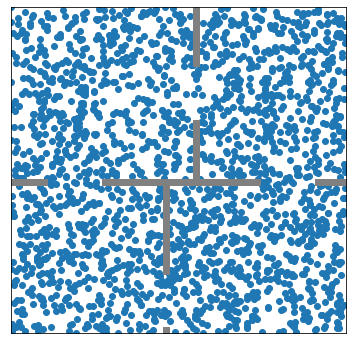

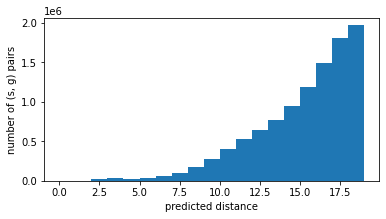

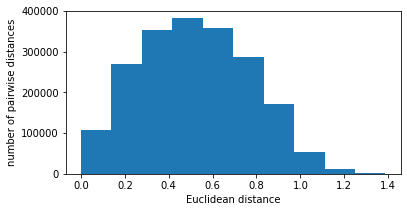

SoRB has initial success rate 0.00
Evaluated initial SoRB success rate in 681.95 seconds
After filtering and 0 cleanup steps, SoRB has success rate 0.20
Took 5000 cleanup steps and evaluated SoRB success rate in 5510.34 seconds
After filtering and 5000 cleanup steps, SoRB has success rate 0.10
Took 5000 cleanup steps and evaluated SoRB success rate in 3546.42 seconds
After filtering and 10000 cleanup steps, SoRB has success rate 0.05
Took 5000 cleanup steps and evaluated SoRB success rate in 4144.29 seconds
After filtering and 15000 cleanup steps, SoRB has success rate 0.10
Took 5000 cleanup steps and evaluated SoRB success rate in 4320.27 seconds
After filtering and 20000 cleanup steps, SoRB has success rate 0.05
Took 5000 cleanup steps and evaluated SoRB success rate in 4652.53 seconds
After filtering and 25000 cleanup steps, SoRB has success rate 0.05
Took 5000 cleanup steps and evaluated SoRB success rate in 3861.09 seconds
After filtering and 30000 cleanup steps, SoRB has success 

In [4]:
generalized_difficulty(5)